<a href="https://colab.research.google.com/github/Fabchirajoul/Transformer_MLM_AND_BINARY_CLASSIFICATION/blob/main/DistilRoberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install accelerate -U

In [ ]:
pip install evaluate

In [ ]:
pip install transformers

In [ ]:
pip install datasets

In [ ]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='latin-1') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Finetunetext.csv"
# input_document = "/content/classification_dataset.csv"
output_sample = "/content/testing_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='latin-1') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Finetunetext.csv"
# input_document = "/content/classification_dataset.csv"
output_sample = "/content/training_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='latin-1') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Finetunetext.csv"
# input_document = "/content/classification_dataset.csv"
output_sample = "/content/validation_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix



from transformers import TrainerCallback
from torch.utils.data import DataLoader
from transformers import get_scheduler
from transformers import AutoTokenizer
from accelerate import Accelerator

from datasets import load_dataset
from transformers import pipeline
from transformers import AdamW
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import  pandas as pd
import numpy as np

import evaluate
import random
import torch
import math

In [ ]:
data_files = {"train": "/content/training_dataset_classification.csv",
              "validation": "/content/validation_dataset_classification.csv",
              "test": "/content/testing_dataset_classification.csv"
              }
df_DistilRoberta = load_dataset("csv", data_files=data_files)
df_DistilRoberta

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

In [ ]:
# DistilRoberta

checkpoint = "distilbert/distilroberta-base"
tokenizer_classification = AutoTokenizer.from_pretrained(checkpoint)
model_classification = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function_classification(df):
    return tokenizer_classification(
        df["text"],
        truncation=True,
        padding="max_length",
        max_length=len(df_DistilRoberta)
        )

tokenized_datasets_classification = df_DistilRoberta.map(tokenize_function_classification, batched=True)
data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer_classification)
tokenized_datasets_classification

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})

In [ ]:
tokenized_datasets_classification = df_DistilRoberta.map(tokenize_function_classification, batched=True)
data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer_classification)
tokenized_datasets_classification

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})

In [ ]:
columns_to_remove_classification = ['text']

tokenized_datasets_classification = tokenized_datasets_classification.remove_columns(columns_to_remove_classification)
tokenized_datasets_classification = tokenized_datasets_classification.rename_column("label", "labels")
tokenized_datasets_classification.set_format("torch")
tokenized_datasets_classification["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [ ]:
# Check the expected input size from the model's configuration
batch_size = 10

train_dataloader_classification = DataLoader(
    tokenized_datasets_classification["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator_classification
)
eval_dataloader_classification = DataLoader(
    tokenized_datasets_classification["validation"], batch_size=batch_size, collate_fn=data_collator_classification
)

In [ ]:
for batch in train_dataloader_classification:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([10]),
 'input_ids': torch.Size([10, 3]),
 'attention_mask': torch.Size([10, 3])}

In [ ]:
outputs_classification = model_classification(**batch)
print(outputs_classification.loss, outputs_classification.logits.shape)

tensor(0.6387, grad_fn=<NllLossBackward0>) torch.Size([10, 2])


In [ ]:
optimizer_classification = torch.optim.AdamW(model_classification.parameters(), lr=5e-5)

In [ ]:
num_epochs_classification = 10

num_training_steps_classification = num_epochs_classification * len(train_dataloader_classification)
lr_scheduler_classification = get_scheduler(
    "linear",
    optimizer=optimizer_classification,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_classification,
)
print(num_training_steps_classification)

700


In [ ]:
device_classification = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_classification.to(device_classification)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
accelerator_classification = Accelerator()

train_dataloader_classification, eval_dataloader_classification, model_classification, optimizer_classification = accelerator_classification.prepare(
    train_dataloader_classification,
    eval_dataloader_classification,
    model_classification,
    optimizer_classification
)

In [ ]:
# function to train the model
def train(

    model=model_classification,
    train_dataloader=train_dataloader_classification,
    optimizer=optimizer_classification,
    # cross_entropy=cross_entropy,
    device=device_classification,
    eval_dataset=eval_dataloader_classification,
):

  model_classification.train()

progress_bar_classification = tqdm(range(num_training_steps_classification))

for epoch in range(num_epochs_classification):
    for batch in train_dataloader_classification:
        batch = {k: v.to(device_classification) for k, v in batch.items()}
        outputs_classification = model_classification(**batch)
        loss_classification = outputs_classification.loss
        loss_classification.backward()

        optimizer_classification.step()
        lr_scheduler_classification.step()
        optimizer_classification.zero_grad()
        progress_bar_classification.update(1)


  0%|          | 0/700 [00:00<?, ?it/s]

In [ ]:
# Define your compute_metrics function to accept predictions and labels
def compute_metrics_classification(predictions_classification, labels_classification):
    # Compute your metrics here using predictions and labels
    # For example:
    accuracy_classification = accuracy_score(labels_classification, predictions_classification)
    precision_classification = precision_score(labels_classification, predictions_classification)
    recall_classification = recall_score(labels_classification, predictions_classification)
    f1_classification = f1_score(labels_classification, predictions_classification)

    return {
        'accuracy_classification': accuracy_classification,
        'precision_classification': precision_classification,
        'recall_classification': recall_classification,
        'f1_classification': f1_classification
    }

# Initialize lists to store metrics for each epoch
epoch_data_classification = []

# Training loop
for epoch in range(num_epochs_classification):
    # Train the model
    model_classification.train()
    for batch in train_dataloader_classification:
        batch = {k: v.to(device_classification) for k, v in batch.items()}
        outputs_classification = model_classification(**batch)
        loss_classification = outputs_classification.loss
        loss_classification.backward()
        optimizer_classification.step()
        lr_scheduler_classification.step()
        optimizer_classification.zero_grad()

    # Evaluate the model
    model_classification.eval()
    # Lists to store predictions and labels
    all_predictions_classification = []
    all_labels_classification = []

    # Losses
    total_train_loss_classification = 0.0
    total_val_loss_classification = 0.0

    # Training loop
    for batch in eval_dataloader_classification:
        batch = {k: v.to(device_classification) for k, v in batch.items()}
        with torch.no_grad():
            outputs_classification = model_classification(**batch)
            loss_classification = outputs_classification.loss
            logits = outputs_classification.logits
            predictions = torch.argmax(logits, dim=-1)

            # Append predictions and labels
            all_predictions_classification.extend(predictions.tolist())
            all_labels_classification.extend(batch["labels"].tolist())

        total_train_loss_classification += loss_classification.item()
        total_val_loss_classification += 1

    average_val_loss_classification = total_train_loss_classification / total_val_loss_classification

    # Calculate metrics
    results = compute_metrics_classification(all_predictions_classification, all_labels_classification)

    # Store metrics for this epoch
    epoch_data_classification.append({
        # 'Epoch': epoch + 1,
        'Training Loss': loss_classification.item(),
        'Validation Loss': average_val_loss_classification,
        'Accuracy': results['accuracy_classification'],
        'Precision': results['precision_classification'],
        'Recall': results['recall_classification'],
        'F1 Score': results['f1_classification']
    })

    # Print metrics for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs_classification}")


# Convert epoch data to DataFrame
epoch_df_classification = pd.DataFrame(epoch_data_classification)

# Print epoch data in tabular format
print(epoch_df_classification.to_string(index=False))

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
 Training Loss  Validation Loss  Accuracy  Precision   Recall  F1 Score
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228
      0.423062         0.463339      0.71   0.712121 0.824561  0.764228


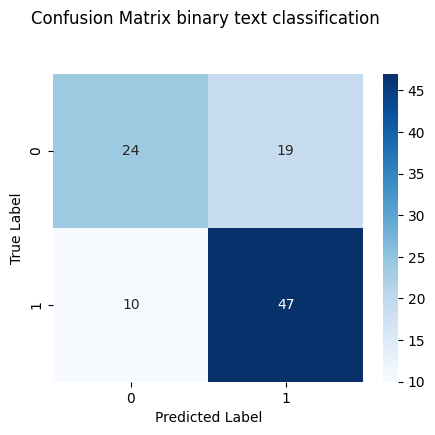

In [ ]:
# Calculate confusion matrix
conf_matrix_classification = confusion_matrix(all_labels_classification, all_predictions_classification)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_classification, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix binary text classification \n\n')
plt.show()

In [ ]:
# Create a text classification pipeline
text_classifier = pipeline(
    "text-classification",
    model=model_classification,
    tokenizer=tokenizer_classification,
    device=device_classification
)


# Function to evaluate a single text input
def evaluate_text_input(text_input):
    result = text_classifier(text_input)
    print(f"Input: {text_input}")
    print(f"Predicted Label: {result[0]['label']}")
    print(f"Predicted Probability: {result[0]['score']:.4f}")
    print("===================================")

# Example text inputs for evaluation
text_inputs_to_evaluate = [
    "In 2016 AbbVie decided to take a leadership approach to climate change by setting new aggressive targets to reduce emissions.  Our GHG reduction target is to reduce emissions 25% absolute, by 2025 with a 2015 baseline.  All GHG targets are combined scope 1 and 2 market based.  All quantities reported in this section are in Metric Tons of CO2e.  It should be noted that the CO2e emissions associated with the acquisition of Stemcentrx and Pharmacyclics as well as a new R&D center in Cambridge, MA are not included in the target calculation because they were not included in the 2015 baseline.  The CO2 emissions from these three businesses account for less than 1% of the total AbbVie CO2e emissions. In early 2020 AbbVie initiated the process of setting a science-based carbon target.  We submitted a letter of commitment to SBTi in June of 2021, and we anticipate setting a science-based target in 2022.",
    "18 Consolidated Scope 1, Scope 2 and selected Scope 3 GHG emissions (accounting for renewable electricity purchased in the UK) are for the environmental reporting year of 1 July – 30 June.",
    "Major pollutants  have been cut by 17%",
    "Scope 3 footprint 2018 includes 10 relevant scope 3 categories including purchased goods and services that are estimated at 90% of total scope 3. We are in the process of collecting supplier emission data via CDP SC for the first time in 2021,  and will be able to report on the progress against this target from 2022.",
]

# Evaluate each text input
for text_input in text_inputs_to_evaluate:
    evaluate_text_input(text_input)


Input: In 2016 AbbVie decided to take a leadership approach to climate change by setting new aggressive targets to reduce emissions.  Our GHG reduction target is to reduce emissions 25% absolute, by 2025 with a 2015 baseline.  All GHG targets are combined scope 1 and 2 market based.  All quantities reported in this section are in Metric Tons of CO2e.  It should be noted that the CO2e emissions associated with the acquisition of Stemcentrx and Pharmacyclics as well as a new R&D center in Cambridge, MA are not included in the target calculation because they were not included in the 2015 baseline.  The CO2 emissions from these three businesses account for less than 1% of the total AbbVie CO2e emissions. In early 2020 AbbVie initiated the process of setting a science-based carbon target.  We submitted a letter of commitment to SBTi in June of 2021, and we anticipate setting a science-based target in 2022.
Predicted Label: LABEL_1
Predicted Probability: 0.6155
Input: 18 Consolidated Scope 1